## CS184a Final Project
#### 2023-12-08

****

Notebook Help From:
- https://www.kaggle.com/code/zulqarnainali/explained-critical-point-rnn/notebook
- https://towardsdatascience.com/deep-learning-on-a-combination-of-time-series-and-tabular-data-b8c062ff1907
- https://www.kaggle.com/code/aiaiaidavid/detect-sleep-states-interactive-eda-and-nn-model/notebook
- https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-recurrent-neural-networks
- https://www.kaggle.com/competitions/child-mind-institute-detect-sleep-states/discussion/437264

Imports

In [1]:
import gc
import numpy as np
import pandas as pd
from keras.models import Model
from keras.layers import Input, Dense, Bidirectional, GRU
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.callbacks import EarlyStopping

Constants

In [2]:
BASE_PATH = "./data/child-mind-institute-detect-sleep-states/"
SAMPLE_STEP_WINDOW_SIZE = 150
SAMPLE_STEP_WINDOW_SIZE_HALF = SAMPLE_STEP_WINDOW_SIZE // 2
FEATURES = [
    "anglez",
    "enmo",
    "anglez_difference",
    "enmo_difference",
    "anglez_rolling_mean",
    "enmo_rolling_mean",
]
BATCH_SIZE = 32
EPOCHS = 100
LEARNING_RATE = 0.001

Load and clean data functions

In [3]:
def clean_data(data: pd.DataFrame) -> pd.DataFrame:
    a = len(data)
    data = data.dropna(subset=["timestamp"])
    b = len(data)

    print(f"dropped {a-b} row(s)")
    return data


def load_data(path: str) -> pd.DataFrame:
    data = None
    ext = path.split(".")[-1]
    if ext == "parquet":
        data = pd.read_parquet(path)
    elif ext == "csv":
        data = pd.read_csv(path)
    else:
        raise (f"{ext} is not valid datatype.")

    return data

Load and clean data

In [4]:
train_series = load_data(BASE_PATH + "train_series.parquet")
test_series = load_data(BASE_PATH + "test_series.parquet")
train_events = load_data(BASE_PATH + "train_events.csv")

train_events = clean_data(train_events)  # remove rows with missing info

# remove days/nights with only one event
train_events = train_events[
    ~(
        ((train_events["series_id"] == "0ce74d6d2106") & (train_events["night"] == 20))
        | (
            (train_events["series_id"] == "154fe824ed87")
            & (train_events["night"] == 30)
        )
        | (
            (train_events["series_id"] == "44a41bba1ee7")
            & (train_events["night"] == 10)
        )
        | ((train_events["series_id"] == "efbfc4526d58") & (train_events["night"] == 7))
        | (
            (train_events["series_id"] == "f8a8da8bdd00")
            & (train_events["night"] == 17)
        )
    )
].reset_index(drop=True)

print("train series:", len(train_series))
print("test series:", len(test_series))
print("train events:", len(train_events))

dropped 4923 row(s)
train series: 127946340
test series: 450
train events: 9580


In [29]:
train_series.info()

train_events.info()

test_series.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127946340 entries, 0 to 127946339
Data columns (total 5 columns):
 #   Column     Dtype  
---  ------     -----  
 0   series_id  object 
 1   step       uint32 
 2   timestamp  object 
 3   anglez     float32
 4   enmo       float32
dtypes: float32(2), object(2), uint32(1)
memory usage: 3.3+ GB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9580 entries, 0 to 9579
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   series_id  9580 non-null   object 
 1   night      9580 non-null   int64  
 2   event      9580 non-null   object 
 3   step       9580 non-null   float64
 4   timestamp  9580 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 374.3+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 450 entries, 0 to 449
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0 

List all unique series IDs in training events data (data with labels) 

In [5]:
series_ids_list = list(
    train_events["series_id"].unique()
)  # unique list of all series ids

print(len(series_ids_list), "unique series ids")

269 unique series ids


Subsample data

In [6]:
# full_series = series_ids_list
# selected_series = random.sample(full_series, len(series_ids_list))

# train_series = train_series[train_series["series_id"].isin(selected_series)]
# train_events = train_events[train_events["series_id"].isin(selected_series)]

Merge training series and training events into one DataFrame

In [7]:
train_series_with_events = pd.merge(
    train_series, train_events, on=["series_id", "step", "timestamp"], how="outer"
).reset_index(drop=True)

In [8]:
train_series_with_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127946340 entries, 0 to 127946339
Data columns (total 7 columns):
 #   Column     Dtype  
---  ------     -----  
 0   series_id  object 
 1   step       uint32 
 2   timestamp  object 
 3   anglez     float32
 4   enmo       float32
 5   night      float64
 6   event      object 
dtypes: float32(2), float64(1), object(3), uint32(1)
memory usage: 5.2+ GB


Separate by events (onset and wake)
- create 150 step (12 min 30 sec) windows around each event.
- pad if step does not exist

In [9]:
onset_records = list(
    train_series_with_events[train_series_with_events["event"] == "onset"].index
)  # list with only onset events

onset_samples = {}

for id in onset_records:
    # print(id)
    onset_samples[id] = train_series_with_events.iloc[
        id - SAMPLE_STEP_WINDOW_SIZE_HALF : id + SAMPLE_STEP_WINDOW_SIZE_HALF
    ].copy()
    onset_samples[id]["asleep"] = 0
    onset_samples[id]["asleep"] = onset_samples[id]["event"].replace({"onset": 1})
    onset_samples[id]["asleep"] = onset_samples[id]["asleep"].ffill(axis="rows")
    onset_samples[id]["asleep"].fillna(value=0, inplace=True)

onset_num = len(onset_samples.keys())
onset_samples = pd.concat(onset_samples, axis=0)


wake_records = list(
    train_series_with_events[train_series_with_events["event"] == "wakeup"].index
)  # list with only wake events

wake_samples = {}

for id in wake_records:
    wake_samples[id] = train_series_with_events.iloc[
        id - SAMPLE_STEP_WINDOW_SIZE_HALF : id + SAMPLE_STEP_WINDOW_SIZE_HALF
    ].copy()
    wake_samples[id]["asleep"] = 0
    wake_samples[id]["asleep"] = wake_samples[id]["event"].replace({"wakeup": 1})
    wake_samples[id]["asleep"] = wake_samples[id]["asleep"].bfill(axis="rows")
    wake_samples[id]["asleep"].fillna(value=0, inplace=True)

wake_num = len(wake_samples.keys())
wake_samples = pd.concat(wake_samples, axis=0)


print(onset_num, "onset samples for training")
print(wake_num, "wake samples for training")

4790 onset samples for training
4790 wake samples for training


Create new features for onset and wake samples: 
- ENMO difference from previous row
- AngleZ difference from previous row
- ENMO one minute rolling mean 
- AngleZ one minute rolling mean 
- is asleep or not (1 or 0)

In [10]:
onset_with_features = onset_samples[["series_id", "asleep", "anglez", "enmo"]]
wake_with_features = wake_samples[["series_id", "asleep", "anglez", "enmo"]]

# onset_samples.info()
# print(onset_samples["enmo"])
# print(onset_samples["enmo"].diff(1))

onset_with_features["enmo_difference"] = onset_samples["enmo"].diff(1)
onset_with_features["anglez_difference"] = onset_samples["anglez"].diff(1)
onset_with_features["enmo_rolling_mean"] = onset_samples["enmo"].rolling(12).mean()
onset_with_features["anglez_rolling_mean"] = onset_samples["anglez"].rolling(12).mean()

wake_with_features["enmo_difference"] = wake_samples["enmo"].diff(1)
wake_with_features["anglez_difference"] = wake_samples["anglez"].diff(1)
wake_with_features["enmo_rolling_mean"] = wake_samples["enmo"].rolling(12).mean()
wake_with_features["anglez_rolling_mean"] = wake_samples["anglez"].rolling(12).mean()

samples_with_features = pd.concat([onset_with_features, wake_with_features], axis=0)
# samples_with_features = samples_with_features.fillna(method="ffill").fillna(method="bfill")
samples_with_features = samples_with_features.ffill().bfill()
# samples_with_features = samples_with_features.bfill()

samples_with_features.info()
print(samples_with_features.iloc[145:155])

total_amount_of_training_sample = onset_num + wake_num
print(total_amount_of_training_sample, "samples for training")

/var/folders/ws/x9ylp9qj2qs_dvfvd9jbc8lh0000gn/T/ipykernel_41089/1393878816.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  onset_with_features["enmo_difference"] = onset_samples["enmo"].diff(1)
/var/folders/ws/x9ylp9qj2qs_dvfvd9jbc8lh0000gn/T/ipykernel_41089/1393878816.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  onset_with_features["anglez_difference"] = onset_samples["anglez"].diff(1)
/var/folders/ws/x9ylp9qj2qs_dvfvd9jbc8lh0000gn/T/ipykernel_41089/1393878816.py:10: SettingWithCopyWarning: 
A 

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1437000 entries, (4992, 4917) to (127935564, 127935638)
Data columns (total 8 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   series_id            1437000 non-null  object 
 1   asleep               1437000 non-null  float64
 2   anglez               1437000 non-null  float32
 3   enmo                 1437000 non-null  float32
 4   enmo_difference      1437000 non-null  float32
 5   anglez_difference    1437000 non-null  float32
 6   enmo_rolling_mean    1437000 non-null  float64
 7   anglez_rolling_mean  1437000 non-null  float64
dtypes: float32(4), float64(3), object(1)
memory usage: 117.5+ MB
                series_id  asleep     anglez    enmo  enmo_difference  \
4992  5062   038441c925bb     1.0 -66.725800  0.0043          -0.0003   
      5063   038441c925bb     1.0 -66.897598  0.0057           0.0014   
      5064   038441c925bb     1.0 -66.958801  0.0058     

In [11]:
samples_with_features.iloc[70:80]

series_id  asleep     anglez    enmo  enmo_difference  \
4992 4987  038441c925bb     0.0 -78.783600  0.0094          -0.0006   
     4988  038441c925bb     0.0 -78.697403  0.0098           0.0004   
     4989  038441c925bb     0.0 -78.758102  0.0100           0.0002   
     4990  038441c925bb     0.0 -78.709801  0.0097          -0.0003   
     4991  038441c925bb     0.0 -78.730301  0.0104           0.0007   
     4992  038441c925bb     1.0 -78.690598  0.0099          -0.0005   
     4993  038441c925bb     1.0 -78.664902  0.0099           0.0000   
     4994  038441c925bb     1.0 -78.465897  0.0101           0.0002   
     4995  038441c925bb     1.0 -78.454597  0.0098          -0.0003   
     4996  038441c925bb     1.0 -78.537804  0.0098           0.0000   

           anglez_difference  enmo_rolling_mean  anglez_rolling_mean  
4992 4987           0.085899           0.018750           -73.929400  
     4988           0.086197           0.018250           -76.241959  
     4989          -0.060699           0.014983           -78.548984  
     4990           0.048302           0.010275           -78.633001  
     4991          -0.020500           0.010092           -78.727818  
     4992           0.039703           0.010058           -78.759200  
     4993           0.025696           0.010033           -78.785809  
     4994           0.199005           0.009983           -78.765167  
     4995           0.011299           0.009950           -78.731250  
     4996          -0.083206           0.009917           -78.690642

Convert samples to Numpy array and reshape:
- X
    - 6 features:
        - AngleZ
        - ENMO
        - AngleZ Difference
        - ENMO Difference
        - ENMO one minute rolling mean 
        - AngleZ one minute rolling mean 
- y
    - asleep or not (0, 1)

In [12]:
X = (
    samples_with_features[FEATURES]
    .to_numpy()
    .reshape(total_amount_of_training_sample, SAMPLE_STEP_WINDOW_SIZE, len(FEATURES))
)

y = (
    samples_with_features["asleep"]
    .to_numpy()
    .reshape(total_amount_of_training_sample, SAMPLE_STEP_WINDOW_SIZE)
)

print("X:", X.shape)
print("y:", y.shape)

# print(X)
# print(y)

# X_train = X
# y_train = y

X: (9580, 150, 6)
y: (9580, 150)


Create TensorFlow RNN model:
- Input Layer
- Bidirectional GRU Layer
- Dense Output Layer with Sigmoid activation

In [13]:
input_layer = Input(shape=(SAMPLE_STEP_WINDOW_SIZE, len(FEATURES)))
gru_layer = Bidirectional(GRU(SAMPLE_STEP_WINDOW_SIZE, return_sequences=True))(
    input_layer
)
output_layer = Dense(1, activation="sigmoid")(gru_layer)

RNN = Model(inputs=input_layer, outputs=output_layer)
RNN.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 6)]          0         
                                                                 
 bidirectional (Bidirectiona  (None, 150, 300)         142200    
 l)                                                              
                                                                 
 dense (Dense)               (None, 150, 1)            301       
                                                                 
Total params: 142,501
Trainable params: 142,501
Non-trainable params: 0
_________________________________________________________________


2023-12-08 00:08:19.807644: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-08 00:08:19.808887: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-08 00:08:19.809333: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Train RNN Model:
- Adam optimizer
- BinaryCrossEntropy loss function
- 0.001 learning_rate
- Callback for Early Stopping if the model loss is no longer decreasing

In [14]:
loss = BinaryCrossentropy()
optimizer = Adam(learning_rate=LEARNING_RATE)

RNN.compile(optimizer=optimizer, loss=loss)

history = RNN.fit(
    X,
    y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[EarlyStopping(monitor="loss", patience=3)],
)

Epoch 1/100


2023-12-08 00:08:20.022972: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-12-08 00:08:20.147967: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-08 00:08:20.148639: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-08 00:08:20.149248: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG IN

300/300 [==============================] - 27s 86ms/step - loss: 0.4537
Epoch 2/100
300/300 [==============================] - 28s 92ms/step - loss: 0.3484
Epoch 3/100
300/300 [==============================] - 30s 99ms/step - loss: 0.2830
Epoch 4/100
300/300 [==============================] - 29s 98ms/step - loss: 0.2478
Epoch 5/100
300/300 [==============================] - 30s 99ms/step - loss: 0.2194
Epoch 6/100
300/300 [==============================] - 31s 105ms/step - loss: 0.1961
Epoch 7/100
300/300 [==============================] - 31s 103ms/step - loss: 0.1893
Epoch 8/100
300/300 [==============================] - 31s 102ms/step - loss: 0.1757
Epoch 9/100
300/300 [==============================] - 30s 101ms/step - loss: 0.1724
Epoch 10/100
300/300 [==============================] - 31s 104ms/step - loss: 0.1600
Epoch 11/100
300/300 [==============================] - 31s 102ms/step - loss: 0.1556
Epoch 12/100
300/300 [==============================] - 31s 104ms/step - loss: 0

Plot loss of the data over the number of epochs

<Axes: title={'center': 'RNN Training Loss'}>

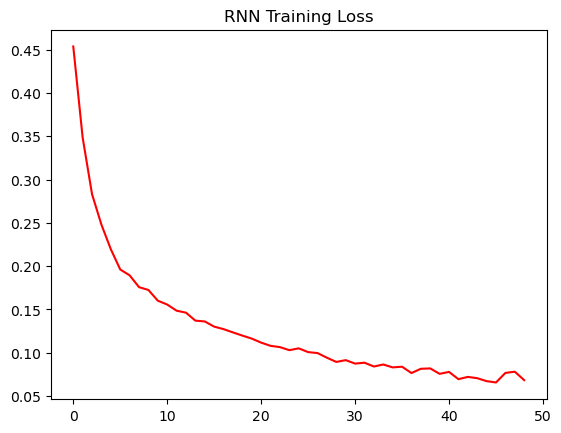

In [15]:
pd.DataFrame(history.history)["loss"].plot(title="RNN Training Loss", color="red")

Save model

In [16]:
RNN.save(f"RNN_{len(series_ids_list)}_SERIES_{EPOCHS}_EPOCHS")

2023-12-08 00:34:08.916207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-08 00:34:08.916905: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-08 00:34:08.917483: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

INFO:tensorflow:Assets written to: RNN_269_SERIES_100_EPOCHS/assets


INFO:tensorflow:Assets written to: RNN_269_SERIES_100_EPOCHS/assets


Collect garbage

In [17]:
gc.collect()

86863

Create unique list of test series IDs

In [18]:
test_series_ids_list = list(test_series["series_id"].unique())
print(len(test_series_ids_list), "test series for submission")
print(test_series_ids_list)

3 test series for submission
['038441c925bb', '03d92c9f6f8a', '0402a003dae9']


Create/format test samples DataFrame

In [19]:
test_samples = {}

for id in test_series_ids_list:
    test_samples[id] = test_series[test_series["series_id"] == id].reset_index(
        drop=True
    )

    samples_list = list(range(len(test_samples[id]) // SAMPLE_STEP_WINDOW_SIZE))
    samples = {}
    for s in samples_list:
        first_step = SAMPLE_STEP_WINDOW_SIZE * s
        samples[s] = test_samples[id].loc[
            first_step : first_step + SAMPLE_STEP_WINDOW_SIZE - 1
        ]
test_samples[id] = pd.concat([samples[s] for s in samples_list], axis="rows")

test_series = pd.concat(
    [test_samples[id] for id in test_series_ids_list], axis="rows"
).reset_index(drop=True)

# test_series.info()

Create new features for test series: 
- ENMO difference from previous row
- AngleZ difference from previous row
- ENMO one minute rolling mean 
- AngleZ one minute rolling mean 

In [20]:
test_series_with_features = {}

for id in test_series_ids_list:
    test_series_with_features[id] = test_series[test_series["series_id"] == id]
    test_series_with_features[id]["anglez_difference"] = (
        test_series_with_features[id]["anglez"].diff().bfill().ffill()
    )
    test_series_with_features[id]["enmo_difference"] = (
        test_series_with_features[id]["enmo"].diff().bfill().ffill()
    )
    test_series_with_features[id]["anglez_rolling_mean"] = (
        test_series_with_features[id]["anglez"].rolling(12).mean().bfill().ffill()
    )
    test_series_with_features[id]["enmo_rolling_mean"] = (
        test_series_with_features[id]["enmo"].rolling(12).mean().bfill().ffill()
    )

test_series = pd.concat(
    [test_series_with_features[id] for id in test_series_ids_list], axis=0
)

/var/folders/ws/x9ylp9qj2qs_dvfvd9jbc8lh0000gn/T/ipykernel_41089/4237076907.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_series_with_features[id]["anglez_difference"] = (
/var/folders/ws/x9ylp9qj2qs_dvfvd9jbc8lh0000gn/T/ipykernel_41089/4237076907.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_series_with_features[id]["enmo_difference"] = (
/var/folders/ws/x9ylp9qj2qs_dvfvd9jbc8lh0000gn/T/ipykernel_41089/4237076907.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of

Make predictions on test set

In [21]:
## https://www.kaggle.com/code/aiaiaidavid/detect-sleep-states-interactive-eda-and-nn-model/notebook

X_test = (
    test_series[FEATURES]
    .to_numpy()
    .reshape(len(test_series_ids_list), SAMPLE_STEP_WINDOW_SIZE, len(FEATURES))
)

# Make submission predictions (probabilities of asleep)
test_predictions = RNN.predict(X_test)

# Make binary asleep predictions (1=asleep)
test_classes = np.where(test_predictions > 0.5, 1, 0)

# Reshape
test_predictions = test_predictions.reshape(len(test_series), 1)
test_classes = test_classes.reshape(len(test_series), 1)

# Create asleep and event predictions columns
test_series["score"] = test_predictions
test_series["asleep"] = test_classes
test_series["asleep_difference"] = test_series["asleep"].diff().bfill().ffill()
test_series["event"] = test_series[test_series["score"] > 0.4][
    "asleep_difference"
].replace({1: "onset", -1: "wakeup"})

2023-12-08 00:34:13.026692: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-08 00:34:13.027285: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-08 00:34:13.027912: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 352ms/step


Create submission in Kaggle format

In [22]:
submission = (
    test_series.loc[
        ((test_series["event"] == "onset") | (test_series["event"] == "wakeup"))
    ][["series_id", "step", "event", "score"]]
    .copy()
    .reset_index(drop=True)
    .reset_index(names="row_id")
)

submission

,row_id,series_id,step,event,score
0,0,038441c925bb,3,wakeup,0.467221
1,1,038441c925bb,19,onset,0.677479
2,2,038441c925bb,75,onset,0.546805
3,3,038441c925bb,149,wakeup,0.487548
4,4,03d92c9f6f8a,3,onset,0.545985
5,5,03d92c9f6f8a,4,wakeup,0.442696
6,6,03d92c9f6f8a,10,onset,0.521569
7,7,03d92c9f6f8a,70,wakeup,0.458847
8,8,0402a003dae9,0,onset,0.852695
9,9,0402a003dae9,85,onset,0.552598
